# Titanic - Machine Learning from Disaster

In [38]:
%conda install pandas scikit-learn numpy

Solving environment: ...working... done

# All requested packages already installed.

Note: you may need to restart the kernel to use updated packages.
Solving environment: ...working... done

# All requested packages already installed.




In [39]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

sys.path.insert(0, '../helpers')

from calculate_average import calculate_average

sys.path.insert(0, './helpers')

from one_hot_encode_passenger_sex import one_hot_encode_passenger_sex
from one_hot_encode_adult_or_child import one_hot_encode_adult_or_child
from one_hot_encode_passenger_class import one_hot_encode_passenger_class

Set options for Pandas.

In [40]:
pd.options.display.max_rows = 999

Set up directory variables.

In [41]:
dataset = "titanic"
dataset_directory = f"../../datasets/{dataset}"
training_dataset_directory = f"{dataset_directory}/train.csv"
test_dataset_directory = f"{dataset_directory}/test.csv"

In [42]:
titanic_train_dataframes = pd.read_csv(training_dataset_directory)
titanic_train_dataframes.head(n=25)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


# Transformations

## Data Cleaning

In [43]:
ages = titanic_train_dataframes["Age"].values.reshape(-1, 1)
average_age = calculate_average(ages)
titanic_train_dataframes["Age"].fillna(value=average_age, inplace=True)
ages = titanic_train_dataframes["Age"]

fares = titanic_train_dataframes["Fare"].values.reshape(-1, 1)
average_fare = calculate_average(fares)

## Feature Engineering Notes

All `master`s (see `Name` column) were 12 or younger. Sources I've seen in preliminary research consider 12 and under (or under 12?) to be the child/adult cut off.

Should probably have a break out for child / adult and mother / father / son / daughter based on Parch > 0 and the ages above. 

1. One hot encoding the sex of each passenger. 
1. One hot encode whether each passenger is an adult or child.
1. One hot encode passenger class to first, second, and third class.

In [44]:
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

titanic_train_dataframes = one_hot_encode_passenger_sex(one_hot_encoder=one_hot_encoder, titanic_dataframes=titanic_train_dataframes)
titanic_train_dataframes = one_hot_encode_adult_or_child(titanic_dataframes=titanic_train_dataframes, ages=ages)
titanic_train_dataframes = one_hot_encode_passenger_class(one_hot_encoder=one_hot_encoder, titanic_dataframes=titanic_train_dataframes)


## Dropping Unnecessary Columns

In [45]:
titanic_train_dataframes.drop(['Sex'] ,axis=1, inplace=True)
titanic_train_dataframes.drop(['PassengerId'] ,axis=1, inplace=True)
titanic_train_dataframes.drop(['Name'] ,axis=1, inplace=True)
titanic_train_dataframes.drop(['Embarked'] ,axis=1, inplace=True)
titanic_train_dataframes.drop(['Ticket'] ,axis=1, inplace=True)
titanic_train_dataframes.drop(['Cabin'] ,axis=1, inplace=True)
titanic_train_dataframes.drop(['Pclass'] ,axis=1, inplace=True)
titanic_train_dataframes.drop(['Fare'] ,axis=1, inplace=True)


In [46]:
y = titanic_train_dataframes["Survived"]

titanic_train_dataframes.drop(['Survived'] ,axis=1, inplace=True)

X = titanic_train_dataframes

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=13
)
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "ls"
}

Print the final training set.

In [48]:
titanic_train_dataframes.head(n=25)

,Age,SibSp,Parch,Sex_female,Sex_male,isAdult,isChild,Pclass_1,Pclass_2,Pclass_3
0,22.000000,1,0,0.0,1.0,1,0,0.0,0.0,1.0
1,38.000000,1,0,1.0,0.0,1,0,1.0,0.0,0.0
2,26.000000,0,0,1.0,0.0,1,0,0.0,0.0,1.0
3,35.000000,1,0,1.0,0.0,1,0,1.0,0.0,0.0
4,35.000000,0,0,0.0,1.0,1,0,0.0,0.0,1.0
5,23.799293,0,0,0.0,1.0,1,0,0.0,0.0,1.0
6,54.000000,0,0,0.0,1.0,1,0,1.0,0.0,0.0
7,2.000000,3,1,0.0,1.0,0,1,0.0,0.0,1.0
8,27.000000,0,2,1.0,0.0,1,0,0.0,0.0,1.0
9,14.000000,1,0,1.0,0.0,1,0,0.0,1.0,0.0


In [49]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 0.1031


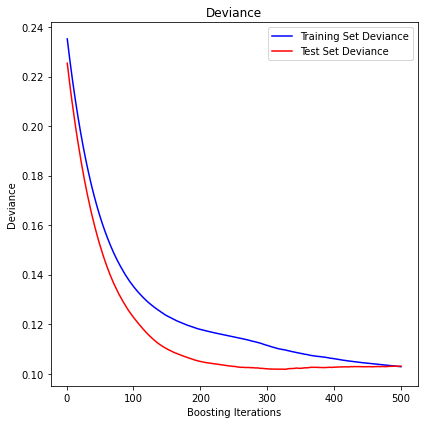

In [50]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

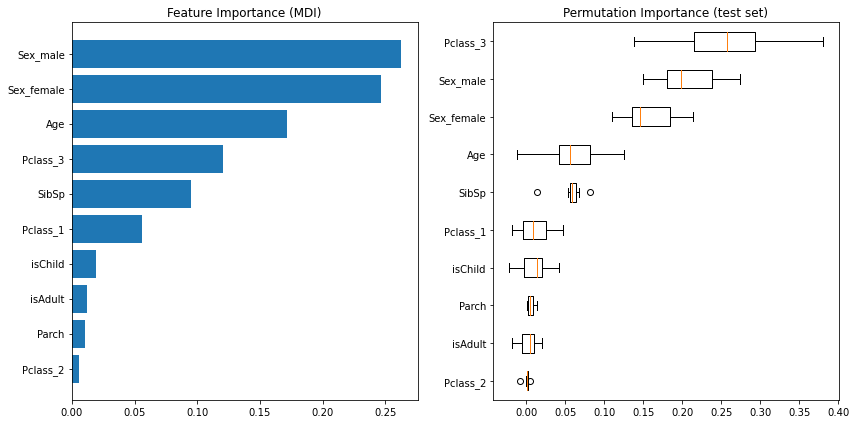

In [51]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(titanic_train_dataframes.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(titanic_train_dataframes.columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

In [52]:
titanic_test_dataframes = pd.read_csv(test_dataset_directory)

In [53]:
X_train = X
y_train = y

params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "ls"
}

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=4, min_samples_split=5,
                          n_estimators=500)

In [54]:
titanic_test_dataframes["Age"].fillna(value=average_age, inplace=True)
ages = titanic_test_dataframes["Age"]

titanic_test_dataframes["Fare"].fillna(value=average_fare, inplace=True)

titanic_test_dataframes = one_hot_encode_passenger_sex(one_hot_encoder=one_hot_encoder, titanic_dataframes=titanic_test_dataframes)
titanic_test_dataframes = one_hot_encode_adult_or_child(titanic_dataframes=titanic_test_dataframes, ages=ages)
titanic_test_dataframes = one_hot_encode_passenger_class(one_hot_encoder=one_hot_encoder, titanic_dataframes=titanic_test_dataframes)

passenger_ids = titanic_test_dataframes['PassengerId'].values.reshape(-1, 1)

titanic_test_dataframes.drop(['Sex'] ,axis=1, inplace=True)
titanic_test_dataframes.drop(['PassengerId'] ,axis=1, inplace=True)
titanic_test_dataframes.drop(['Name'] ,axis=1, inplace=True)
titanic_test_dataframes.drop(['Embarked'] ,axis=1, inplace=True)
titanic_test_dataframes.drop(['Ticket'] ,axis=1, inplace=True)
titanic_test_dataframes.drop(['Cabin'] ,axis=1, inplace=True)
titanic_test_dataframes.drop(['Pclass'] ,axis=1, inplace=True)
titanic_test_dataframes.drop(['Fare'] ,axis=1, inplace=True)

titanic_test_dataframes.head(n=25)

,Age,SibSp,Parch,Sex_female,Sex_male,isAdult,isChild,Pclass_1,Pclass_2,Pclass_3
0,34.500000,0,0,0.0,1.0,1,0,0.0,0.0,1.0
1,47.000000,1,0,1.0,0.0,1,0,0.0,0.0,1.0
2,62.000000,0,0,0.0,1.0,1,0,0.0,1.0,0.0
3,27.000000,0,0,0.0,1.0,1,0,0.0,0.0,1.0
4,22.000000,1,1,1.0,0.0,1,0,0.0,0.0,1.0
5,14.000000,0,0,0.0,1.0,1,0,0.0,0.0,1.0
6,30.000000,0,0,1.0,0.0,1,0,0.0,0.0,1.0
7,26.000000,1,1,0.0,1.0,1,0,0.0,1.0,0.0
8,18.000000,0,0,1.0,0.0,1,0,0.0,0.0,1.0
9,21.000000,2,0,0.0,1.0,1,0,0.0,0.0,1.0


In [55]:
predictions = reg.predict(titanic_test_dataframes)
rounded_predictions = [round(value) for value in predictions]

passenger_ids = pd.DataFrame(passenger_ids, columns=["PassengerId"])
rounded_predictions = pd.DataFrame(rounded_predictions, columns=["Survived"])

submission = pd.concat([passenger_ids, rounded_predictions ], axis=1)
submission.head(n=10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0


In [56]:
submission.to_csv("./result/submission_test.csv", index=False)